In [1]:
import contextlib
import glob

from numba import njit
import matplotlib.pyplot as plt
from matplotlib import animation as gif
from matplotlib.colors import Normalize, SymLogNorm
import numpy as np
import utlt

from scipy.constants import hbar, Boltzmann
from scipy.interpolate import UnivariateSpline
from split_op_gpe1D import SplitOpGPE1D, imag_time_gpe1D
from PIL import Image

from itertools import product
from multiprocessing import Pool, Process, Manager
import tqdm
import pickle
import h5py
import sys
import os


In [ ]:
########################################################################################################################
#
# Set parameters here for ease of use
#
########################################################################################################################
# Gaussian Params
waist = 15.                                 # Waist of the gaussian beam
sigma = waist / 2                           # Delta = sqrt(2) sigma, such that delta^2 = 2 * sigma^2
fwhm = 2 * sigma * np.sqrt(2 * np.log(2))   # Full Width, Half Maximum (used for spacing parameters)
barrier_height = 400                        # Barrier height to be subtracted from
gap = fwhm * 0.5
scalable_height = 0.75
asymm_heights = scalable_height * np.array([1, 1.25, 1.175])

# Get times
T = 10
times = np.linspace(0, T, 600)

# Get position grid
pulse_amplitude = 15
buffer = 5
x_amplitude = pulse_amplitude * gap
x_grid_dim = 2 * 1024

# get coordinate step size and generate coordinate range
dx = 2. * x_amplitude / x_grid_dim
x = (np.arange(x_grid_dim) - x_grid_dim / 2) * dx

path = './'

end = 360
first_step = int(end / 3)
second_step = int(2 * end / 3)
times = np.array(range(0, end))
seconds = 6

left_side = 8
right_side = 10

In [ ]:
def ahtd_scaling(t, t_hf, t_cf, height_f, center_f, t_hi=0, t_ci=0, height_i=0, center_i=0):
    """
    Amplitude- & Height- Time Dependent scaling. This is absolutely overkill and should have never been written, but
    now I have it, so you're welcome future me!
    :param position: Position
    :param t: time
    :param t_hi: The time point at which the gaussian center begins increasing in height
    :param t_hf: The time point at which the gaussian center arrived at its max height
    :param t_ci: The time point at which the gaussian center begins translating in space
    :param t_cf: The time point at which the gaussian center arrived at its final destination
    :param height_i: The initial height of the gaussian
    :param height_f: The final height of the gaussian
    :param center_i: The initial position of the center of the gaussian
    :param center_f: The final position of the center of the gaussian
    :return: two arrays of size(times) with height and scaling parameters
    """
    # if t <= t_hi:
    time_factor_h = (t > t_hi) * (t - t_hi) / (t_hf - t_hi)     # 0 for any time before t = t_i and 1 and t = t_f
    time_factor_c = (t > t_ci) * (t - t_ci) / (t_cf - t_ci)     # 0 for any time before t = t_i and 1 and t = t_f
    time_scaling_height = height_i + (height_f - height_i) * time_factor_h
    time_scaling_center = center_i + (center_f - center_i) * time_factor_c
    return [time_scaling_height, time_scaling_center]


def get_gaussian(pos_grid, height, center):
    """
    Returns a single time instance of a Gaussian of specified height and center.
    :param pos_grid:
    :param height:
    :param center:
    :return:
    """
    return height * np.exp(-0.5 * ((pos_grid - center) / sigma) ** 2)


def pulse(pos_grid, width, center):
    """
    Adjustable width Gaussian. Passed as a function for repeated use and readability
    :param pos_grid:
    :param height:
    :param center:
    :param width:
    :return:
    """
    return np.exp(-((pos_grid - center) / width) ** 2)


def create_pulse_library(pos_grid, left_range, right_range):
    pulses = []
    sym_pulses = []
    asymm_pulses = []
    n_asymm = int((len(asymm_heights) - 1) / 2)
    for _ in range(-left_range, right_range + 1):
        if _ < -n_asymm or _ > n_asymm:
            sym_pulses.append([barrier_height, _ * gap])
        elif _ in range(-n_asymm, n_asymm + 1):
            step = int(n_asymm + _)
            asymm_pulses.append([asymm_heights[step] * barrier_height, _ * gap])
    pulse_params = np.concatenate((sym_pulses, asymm_pulses), axis=0)
    for _ in pulse_params:
        pulses.append(get_gaussian(pos_grid, *_))

    return np.array(pulses)




In [ ]:
end = 360
first_step = int(end / 3)
second_step = int(2 * end / 3)
times = np.array(range(0, end))
seconds = 6

left_side = 8
right_side = 10

def generate_images(pos, t, step1, step2, step_end, tp1, tp2, tp1_init, tp2_init, mtp_lib, figure_num,
                    height=barrier_height):
    init_pulses = tp1 + tp2
    mtp_sum = np.sum(mtp_lib, axis=0)
    for _ in t:
        if _ < step1:
            pulse_height = np.sin(0.5 * (_ * np.pi) / (step1 - 1))
            mod = height * pulse_height / init_pulses.max()
            all_pulses = height - init_pulses * mod
            plt.figure(figsize=(8, 6))
            figure_num += 1
            plt.plot(pos, all_pulses)
            plt.plot(pos, height - mod * tp1, linestyle='--')
            plt.plot(pos, height - mod * tp2, linestyle='--')
            plt.xlim(pos.min(), pos.max())
            plt.ylim(-5, height * 1.1)
            plt.tight_layout()
            plt.savefig(path + '{:04d}.png'.format(_))
            plt.close()
        elif step1 <= _ < step2:
            pulse_height = np.sin(0.5 * (_ - step1) * np.pi / (step2 - step1 - 1))
            mod_init = height / init_pulses.max()
            mod_main = height * pulse_height / mtp_sum.max()
            all_pulses = mtp_sum * mod_main + init_pulses * mod_init
            while height - all_pulses.max() < -0.1:
                new_mod = height / all_pulses.max()
                mod_init *= new_mod
                all_pulses = mod_init * init_pulses + mod_main * mtp_sum
            plt.figure(figsize=(8, 6))
            figure_num += 1
            plt.plot(pos, height - all_pulses)
            plt.plot(pos, height - mod_init * tp1, linestyle='--')
            plt.plot(pos, height - mod_init * tp2, linestyle='--')
            for p in mtp_lib:
                plt.plot(pos, height - (pulse_height * mod_main * p), linestyle='--')
            plt.xlim(pos.min(), pos.max())
            plt.ylim(-5, height * 1.1)
            plt.tight_layout()
            plt.savefig(path + '{:04d}.png'.format(_))
            plt.close()
        elif step2 <= _:
            desired_step = tp1_init + (left_side + 2) * gap
            pulse_center = desired_step * 2 * (np.sin(0.25 * (_ - step2) * np.pi / (step_end - step2 - 1)) ** 2)
            kp1 = get_gaussian(pos, height, tp1_init - pulse_center)
            kp2 = get_gaussian(pos, height, (tp2_init - pulse_center))
            init_pulses = kp1 + kp2
            mod = height / init_pulses.max()
            all_pulses = mod * init_pulses + mod_main * mtp_sum
            while height - all_pulses.max() < -0.1:
                new_mod = height / all_pulses.max()
                mod *= new_mod
                all_pulses = mod * init_pulses + mod_main * mtp_sum
            plt.figure(figsize=(8, 6))
            figure_num += 1
            plt.plot(pos, height - all_pulses)
            plt.plot(pos, height - mod * kp1, linestyle='--')
            plt.plot(pos, height - mod * kp2, linestyle='--')
            for p in mtp_lib:
                plt.plot(pos, height - (mod_main * p), linestyle='--')
            plt.xlim(pos.min(), pos.max())
            plt.ylim(-5, height * 1.1)
            plt.tight_layout()
            plt.savefig(path + '{:04d}.png'.format(_))
            plt.close()
    return figure_num

def generate_image2(pos, t, step, init_pulses, mtp_lib, figure_num,
                    height=barrier_height):
    init_pulse_sum = np.sum(init_pulses, axis=0)
    mtp_sum = np.sum(mtp_lib, axis=0)
    for _ in t:
        pulse_height = np.sin(0.5 * (_ - step) * np.pi / (step - 1))
        mod_init = height / init_pulse_sum.max()
        mod_main = height * pulse_height / mtp_sum.max()
        all_pulses = mtp_sum * mod_main + init_pulses * mod_init
        while height - all_pulses.max() < -0.1:
            new_mod = height / all_pulses.max()
            mod_init *= new_mod
            all_pulses = mod_init * init_pulses + mod_main * mtp_sum
        plt.figure(figsize=(8, 6))
        figure_num += 1
        plt.plot(pos, height - all_pulses)
        for p in init_pulses:
            plt.plot(pos, height - mod_init * p, linestyle='--')
        for p in mtp_lib:
            plt.plot(pos, height - (pulse_height * mod_main * p), linestyle='--')
        plt.xlim(pos.min(), pos.max())
        plt.ylim(-5, height * 1.1)
        plt.tight_layout()
        plt.savefig(path + '{:04d}.png'.format(_))
        plt.close()

In [ ]:
########################################################################################################################
# Get the initial parameters and determine pulses for traps
########################################################################################################################
# Trap Frequencies for creating the Quasi-1D case
propagation_freq = 0.5 * 2 * np.pi          # Frequency of the shallow trap along axis of propagation (we use x-axis)
perpendicular_freqs = 200 * 2 * np.pi       # Frequency of the axes perpendicular to propagation (we use y- and z-axis)

# Beam Parameters
waist = 15                                  # Waist of the gaussian beam (dimensionless)
sigma = waist / 2                           # Delta = sqrt(2) sigma, such that delta^2 = 2 * sigma^2
fwhm = 2 * sigma * np.sqrt(2 * np.log(2))   # Full Width, Half Maximum (used for spacing parameters)
delta = 2 * sigma ** 2                      # Minimum Width Parameter for the Gaussian function, pulse()
gap = sigma * np.sqrt(2 * np.log(2))        # Half of Full-width, Half-Max for creating uniform gaps between Gaussians
barrier_height = 400                        # Dimensionless height of the barrier

# Create the position grid and times
pos_grid_dim = 1 * 1024         # Resolution for the position grid (in our case, this is the x-axis resolution)
pos_amplitude = 100             # Code is always centered about 0, so +/- amplitude are the bounds of the position grid
tp_cut = 0.3                    # % of position grid to integrate over for tunneling
T = 1.                          # Final time. Declare as a separate parameter for conversions
times = np.linspace(0, T, 500)  # Time grid: required a resolution of 500 for split operator class
prop_dt = 1e-6                  # Initial guess for the adaptive step propagation

atom_params = dict(
    atom='R87',
    omega_x=propagation_freq,
    omega_y=perpendicular_freqs,
    omega_z=perpendicular_freqs
)

gpe = utlt.BEC(**atom_params)
g = gpe.g
N = gpe.N
kick = 4.5

In [34]:
def pulse(pos_grid, width, center):
    """
    Adjustable width Gaussian. Passed as a function for repeated use and readability
    :param pos_grid:
    :param height:
    :param center:
    :param width:
    :return:
    """
    return np.exp(-((pos_grid - center) / width) ** 2)


In [3]:
########################################################################################################################
# Determine global functions
########################################################################################################################

@njit
def pulse(pos_grid, width, center):
    """
    Adjustable width Gaussian. Passed as a function for repeated use and readability
    :param pos_grid:
    :param height:
    :param center:
    :param width:
    :return:
    """
    return  np.exp(-((pos_grid - center) / width) ** 2)

@njit
def diff_pulse(pos_grid, width, center):
    """
    Derivative of the
    :param pos_grid:
    :param height:
    :param center:
    :param width:
    :return:
    """
    return (-2 / width) * (pos_grid - center) * np.exp(-((pos_grid - center) / width) ** 2)

@njit
def k(p):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2

@njit
def diff_k(p):
    """
    the derivative of the kinetic energy for Ehrenfest theorem evaluation
    """
    return p


########################################################################################################################
# Get the initial parameters and determine pulses for traps
########################################################################################################################
# Trap Frequencies for creating the Quasi-1D case
propagation_freq = 0.5 * 2 * np.pi          # Frequency of the shallow trap along axis of propagation (we use x-axis)
perpendicular_freqs = 200 * 2 * np.pi       # Frequency of the axes perpendicular to propagation (we use y- and z-axis)

# Beam Parameters
waist = 15                                  # Waist of the gaussian beam (dimensionless)
sigma = waist / 2                           # Delta = sqrt(2) sigma, such that delta^2 = 2 * sigma^2
fwhm = 2 * sigma * np.sqrt(2 * np.log(2))   # Full Width, Half Maximum (used for spacing parameters)
delta = 2 * sigma ** 2                      # Minimum Width Parameter for the Gaussian function, pulse()
gap = sigma * np.sqrt(2 * np.log(2))        # Half of Full-width, Half-Max for creating uniform gaps between Gaussians
barrier_height = 400                        # Dimensionless height of the barrier

# Create the position grid and times
pos_grid_dim = 1 * 1024         # Resolution for the position grid (in our case, this is the x-axis resolution)
pos_amplitude = 100             # Code is always centered about 0, so +/- amplitude are the bounds of the position grid
tp_cut = 0.3                    # % of position grid to integrate over for tunneling
T = 0.3                         # Final time. Declare as a separate parameter for conversions
times = np.linspace(0, T, 500)  # Time grid: required a resolution of 500 for split operator class
prop_dt = 1e-5                  # Initial guess for the adaptive step propagation

atom_params = dict(
    atom='R87',
    omega_x=propagation_freq,
    omega_y=perpendicular_freqs,
    omega_z=perpendicular_freqs
)

gpe = utlt.BEC(**atom_params)
g = gpe.g
N = gpe.N
kick = 500

########################################################################################################################
# Create the BEC in a trap
########################################################################################################################


@njit
def initial_trap(x):
    """
    Trapping potential to get the initial state
    :param x:
    :return:
    """
    return 0.25 * (x + (0.5 * pos_amplitude)) ** 2


def run_in_parallel(opt, param):
    print('Beginning {} side GPE propagation with asymm parameter: {:.4f}'.format(param['side'], opt))

    @njit(parallel=True)
    def v(x, t=0):
        """
        Function for the propagation potential
        :param x: position grid as an array
        :param t: time grid as an array
        :return: The potential as a function of x (and t if relevant)
        """
        p1 = (1 - opt) * pulse(x, sigma, 4 * gap)
        p2 = pulse(x, sigma, 3 * gap)
        p3 = (1 + opt) * pulse(x, sigma, 2 * gap)
        p4 = (1 - opt) * pulse(x, sigma, -2 * gap)
        p5 = pulse(x, sigma, -3 * gap)
        p6 = (1 + opt) * pulse(x, sigma, -4 * gap)
        central_potentials = p1 + p2 + p3 + p4 + p5 + p6
        height_mod = barrier_height / central_potentials.max()
        edge_potential = pulse(x, (pos_amplitude / 10) * sigma, pos_amplitude) + \
                         pulse(x, (pos_amplitude / 10) * sigma, -pos_amplitude)
        return height_mod * central_potentials + 10 * height_mod * edge_potential

    @njit(parallel=True)
    def diff_v(x, t=0):
        """

        :param x: position grid as an array
        :param t: time grid as an array
        :return: Derivative of the potential as a function of x (and t if relevant)
        """
        p1 = (1 - opt) * pulse(x, sigma, 4 * gap)
        p2 = pulse(x, sigma, 3 * gap)
        p3 = (1 + opt) * pulse(x, sigma, 2 * gap)
        p4 = (1 - opt) * pulse(x, sigma, -2 * gap)
        p5 = pulse(x, sigma, -3 * gap)
        p6 = (1 + opt) * pulse(x, sigma, -4 * gap)
        pulses = p1 + p2 + p3 + p4 + p5 + p6
        pulses *= barrier_height / pulses.max()
        height_mod = barrier_height / pulses.max()
        central_potential = height_mod * ((1 - opt) * diff_pulse(x, sigma, 4 * gap) +
                             diff_pulse(x, sigma, 3 * gap) +
                             (1 + opt) * diff_pulse(x, sigma, 2 * gap) +
                             (1 - opt) * diff_pulse(x, sigma, -2 * gap) +
                             diff_pulse(x, sigma, -3 * gap) +
                             (1 + opt) * diff_pulse(x, sigma, -4 * gap)
                             )
        edge_potentials = 10 * height_mod * (diff_pulse(x, (pos_amplitude / 10) * sigma, pos_amplitude) +
                                             diff_pulse(x, (pos_amplitude / 10) * sigma, -pos_amplitude))
        return central_potential + edge_potentials

    param['v'] = v
    param['diff_v'] = diff_v
    param['iterator'] = opt

    return np.array(gpe.run_single_case_structured(param))


[-0.     -0.0125 -0.025  -0.0375 -0.05   -0.0625 -0.075  -0.0875 -0.1
 -0.1125 -0.125  -0.1375 -0.15   -0.1625 -0.175  -0.1875 -0.2    -0.2125
 -0.225  -0.2375 -0.25   -0.2625 -0.275  -0.2875 -0.3    -0.3125 -0.325
 -0.3375 -0.35   -0.3625 -0.375  -0.3875 -0.4    -0.4125 -0.425  -0.4375
 -0.45   -0.4625 -0.475  -0.4875 -0.5    -0.5125 -0.525  -0.5375 -0.55
 -0.5625 -0.575  -0.5875 -0.6    -0.6125 -0.625  -0.6375 -0.65   -0.6625
 -0.675  -0.6875 -0.7    -0.7125 -0.725  -0.7375 -0.75   -0.7625 -0.775
 -0.7875 -0.8    -0.8125 -0.825  -0.8375 -0.85   -0.8625 -0.875  -0.8875
 -0.9    -0.9125 -0.925  -0.9375 -0.95   -0.9625 -0.975  -0.9875 -1.    ]
0.1


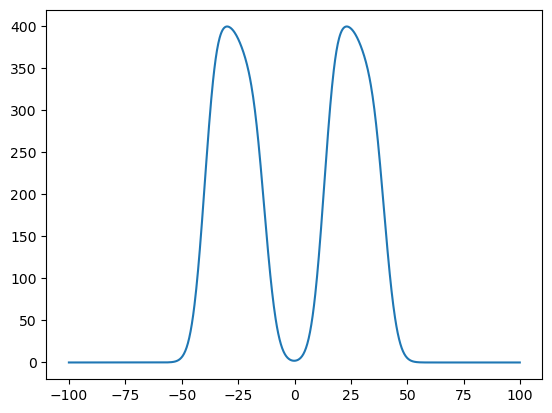

In [62]:
offsets = -1 * np.linspace(0.0, 1.0, 2)
print(offsets)

opt = offsets
print(opt)
def potential(x, t=0):
    """
    Function for the propagation potential
    :param x: position grid as an array
    :param t: time grid as an array
    :return: The potential as a function of x (and t if relevant)
    """
    p1 = (1 - opt) * pulse(x, sigma, 4 * gap)
    p2 = pulse(x, sigma, 3 * gap)
    p3 = (1 + opt) * pulse(x, sigma, 2 * gap)
    p4 = (1 - opt) * pulse(x, sigma, -2 * gap)
    p5 = pulse(x, sigma, -3 * gap)
    p6 = (1 + opt) * pulse(x, sigma, -4 * gap)
    pulses = p1 + p2 + p3 + p4 + p5 + p6
    pulses *= barrier_height / pulses.max()
    return pulses



dx = 2. * pos_amplitude / pos_grid_dim
x = (np.arange(pos_grid_dim) - pos_grid_dim / 2) * dx

plt.plot(x, potential(x))

In [4]:
savespath = './Archive_Data/'
filename = 'Test3'

prob_region = 0.4
# To do, move cooling here pleeeease, that way it only runs twice
left_cool_params = dict(
    x_grid_dim=pos_grid_dim,
    x_amplitude=pos_amplitude,
    k=k,
    initial_trap=initial_trap,
    g=g,
    dt1=1e-3,
    dt2=1e-5,
    eps1=1e-8,
    eps2=1e-10,
)

left_init, left_mu = gpe.cooling(left_cool_params)
right_cool_params = left_cool_params.copy()
right_cool_params['initial_trap'] = njit(lambda x: initial_trap(-x))
right_init, right_mu = gpe.cooling(right_cool_params)
sys_params_left = dict(
    x_amplitude=pos_amplitude,
    x_grid_dim=pos_grid_dim,
    g=g,
    N=N,
    k=k,
    dt=prop_dt,
    init_state=left_init,
    initial_trap=initial_trap,
    diff_k=diff_k,
    times=times,
    init_momentum_kick=kick,
    side='left',
)

# Copy the Left starting params, and then modify so that it starts on the right
sys_params_right = sys_params_left.copy()
sys_params_right['initial_trap'] = njit(lambda x: initial_trap(-x))
sys_params_right['init_state'] = right_init
sys_params_right['init_momentum_kick'] = -sys_params_left['init_momentum_kick']
sys_params_right['side'] = 'right'
offsets = -1 * np.logspace(0.0 * gap, 0.5 * gap, 2)     # Use 41 when this starts working
both_side_params = [sys_params_left, sys_params_right]



Starting imaginary time propagation
current ground state energy = 5.5422e+02
current ground state energy = 1.0232e+02
current ground state energy = 1.0230e+02
current ground state energy = 1.0229e+02
current ground state energy = 1.0228e+02
current ground state energy = 1.0227e+02
current ground state energy = 1.0227e+02
current ground state energy = 1.0226e+02
current ground state energy = 1.0226e+02


Final current ground state energy = 1.0226e+02

Starting imaginary time propagation
current ground state energy = 1.0226e+02


Final current ground state energy = 1.0226e+02

Starting imaginary time propagation
current ground state energy = 5.5422e+02
current ground state energy = 1.0227e+02
current ground state energy = 1.0226e+02


Final current ground state energy = 1.0226e+02

Starting imaginary time propagation
current ground state energy = 1.0226e+02


Final current ground state energy = 1.0226e+02


In [5]:
task = [run_in_parallel(a, b) for a, b in product(offsets, both_side_params)]
results = np.array([_ for _ in task])

####################################################################################################################
# Save the Results
####################################################################################################################
with open(savespath + filename + ".pickle", "wb") as f:
    pickle.dump(results, f)

with open(savespath + filename + ".pickle", "rb") as f:
    loaded = pickle.load(f)


Beginning left side GPE propagation with asymm parameter: -1.0000
Beginning right side GPE propagation with asymm parameter: -1.0000
Beginning left side GPE propagation with asymm parameter: -26018.8193
Beginning right side GPE propagation with asymm parameter: -26018.8193


In [6]:
res_lib = dict()
for o in offsets:
    res_lib['{:.4f}'.format(o)] = dict()
    for _ in loaded:
        if _['parameters']['iterator'] == o:
            res_lib['{:.4f}'.format(o)]['{}'.format(_['parameters']['side'])] = _

x_um = [gpe.convert_time(_, -6) for _ in loaded['x']]
t_ms = [gpe.convert_time(_, -6) for _ in loaded['times']]


In [17]:
opt= ()
def v(x, t=0):
    """
    Function for the propagation potential
    :param x: position grid as an array
    :param t: time grid as an array
    :return: The potential as a function of x (and t if relevant)
    """
    p1 = pulse(x, barrier_height, sigma, 3 * gap)
    p2 = pulse(x, barrier_height, sigma, 0.5 * opt - 2 * gap)
    p3 = pulse(x, barrier_height, sigma, opt - gap)
    p4 = pulse(x, barrier_height, sigma, opt)
    p5 = pulse(x, barrier_height, sigma, opt + gap)
    p6 = pulse(x, barrier_height, sigma, 0.5 * opt + 2 * gap)
    p7 = pulse(x, barrier_height, sigma, 3 * gap)
    pulses = p1 + p2 + p3 + p4 + p5 + p6 + p7
    pulses *= barrier_height / pulses.max()
    return pulses

(500, 1024)


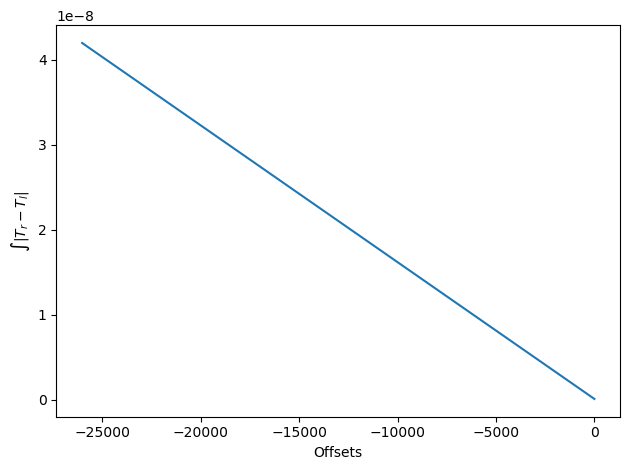

In [7]:
TP_lib = dict()
for _ in res_lib:
    l2r = res_lib[_]['left']
    r2l = res_lib[_]['right']
    l_size = l2r['x'].size  # Create size parameter for probability evaluation
    r_size = r2l['x'].size
    l_cut = int((1 - prob_region) * l_size)  # Use size parameter for Left-to-Right probability
    r_cut = int(prob_region * r_size)  # Use size parameter for Right-to-Left probability
    T_l2r = np.sum(np.abs(l2r['wavefunctions'])[:, l_cut:] ** 2, axis=1) * l2r['dx']
    T_r2l = np.sum(np.abs(r2l['wavefunctions'])[:, :r_cut] ** 2, axis=1) * r2l['dx']
    TP_lib[_] = {'l2r': T_l2r, 'r2l': T_r2l, 'diff': np.sum(np.abs(T_l2r - T_r2l))}

plt.plot(offsets, [TP_lib[_]['diff'] for _ in TP_lib])
plt.xlabel('Offsets')
plt.ylabel('$\int\|T_r - T_l\|$')
plt.tight_layout()
plt.show()

In [63]:
figure_number = 0
TP_lib = dict()
for _ in res_lib:
    l2r = res_lib[_]['left']
    r2l = res_lib[_]['right']
    x_um = gpe.convert_x(res_lib[_]['left']['x'], -6)
    t_ms = gpe.convert_time(times, -6)
    print(np.array(t_ms).shape)
    l_size = l2r['x'].size  # Create size parameter for probability evaluation
    r_size = r2l['x'].size
    l_cut = int((1 - prob_region) * l_size)  # Use size parameter for Left-to-Right probability
    r_cut = int(prob_region * r_size)  # Use size parameter for Right-to-Left probability
    T_l2r = np.sum(np.abs(l2r['wavefunctions'])[:, l_cut:] ** 2, axis=1) * l2r['dx']
    T_r2l = np.sum(np.abs(r2l['wavefunctions'])[:, :r_cut] ** 2, axis=1) * r2l['dx']
    # Plot the Tunneling results
    plt.figure(figure_number, figsize=(8, 6))
    figure_number += 1
    plot_title = 'TunnelingProbability-{}param'.format(_)
    plt.plot(t_ms, T_l2r, label='Tunneling probability from Left to Right')
    plt.plot(t_ms, T_l2r, label='Tunneling probability from Left to Right')
    plt.xlabel('Coordinate $x (\textmu$m))')
    plt.ylabel('Time $t (\textmu$s)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(savespath + plot_title + '.pdf')
    # Plot the Potential
    plot_title = 'Potential-{}param'.format(_)
    x_line = [x_um[0], x_um[-1]]
    en_left = [l2r['hamiltonian_average'], l2r['hamiltonian_average']]
    en_right = [r2l['hamiltonian_average'], r2l['hamiltonian_average']]
    plt.plot(x_um, gpe.convert_energy(l2r['parameters']['v'](l2r['x']), -9))
    plt.plot(x_um, gpe.convert_energy(r2l['parameters']['v'](r2l['x']), -9))
    plt.plot(x_line, gpe.convert_energy(en_left, -9), label='Left Energy')
    plt.plot(x_line, gpe.convert_energy(en_right, -9), label='Right Energy')
    plt.xlabel('Coordinate $x (\mu$m))')
    plt.ylabel('Energy $E$ (nK)')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(savespath + plot_title + '.pdf')
    TP_lib[_] = {'l2r': T_l2r, 'r2l': T_r2l, 'diff': np.sum(np.abs(T_l2r - T_r2l))}

plt.show()

(500,)


C:\Users\Dustin L\AppData\Local\Temp\ipykernel_8620\2155705849.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Dustin L\AppData\Local\Temp\ipykernel_8620\2155705849.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\Dustin L\AppData\Local\Temp\ipykernel_8620\2155705849.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(savespath + plot_title + '.pdf')
C:\Users\Dustin L\AppData\Local\Temp\ipykernel_8620\2155705849.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(savespath + plot_title + '.pdf')


(500,)


C:\Users\Dustin L\AppData\Local\Temp\ipykernel_8620\2155705849.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Dustin L\AppData\Local\Temp\ipykernel_8620\2155705849.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\Dustin L\AppData\Local\Temp\ipykernel_8620\2155705849.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(savespath + plot_title + '.pdf')
C:\Users\Dustin L\AppData\Local\Temp\ipykernel_8620\2155705849.py:39: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(savespath + plot_title + '.pdf')
C:\Users\Dustin L\.conda\envs\GPE\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(byt

ValueError: Image size of 787x183966 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x600 with 1 Axes>

ValueError: Image size of 800x185726 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x600 with 1 Axes>

In [141]:
####################################################################################################################
# Plot the Results
####################################################################################################################
# Pair the results of different iterators together in shared directories
res_lib = dict()
for _ in loaded:
    for o in offsets:
        res_lib['{:.4f}'.format(o)] = dict()
        if _['parameters']['iterator'] == o:
            res_lib['{:.4f}'.format(o)]['{}'.format(_['parameters']['side'])] = _
print(res_lib['{:.4f}'.format(offsets[0])])
x_um = [gpe.convert_time(_, -6) for _ in loaded['x']]
t_ms = [gpe.convert_time(_, -6) for _ in loaded['times']]

{'-1.0000': {'left': [array([-5.63689933e-14-1.02862364e-14j,  5.57403999e-14+1.00699097e-14j,
       -5.65672027e-14-1.00623084e-14j, ...,
        2.04779449e-15+3.90245762e-16j, -2.04396748e-15-3.83659477e-16j,
        1.98919772e-15+3.69543401e-16j]), array([-5.52186335e-14-1.71022051e-14j,  5.47318267e-14+1.67834496e-14j,
       -5.53927564e-14-1.65607545e-14j, ...,
        7.31130606e-16+7.89049902e-15j, -7.37347325e-16-7.65050698e-15j,
        7.08316615e-16+7.56846432e-15j]), array([-5.43198299e-14-2.29998312e-14j,  5.39108688e-14+2.25561757e-14j,
       -5.45722321e-14-2.22395886e-14j, ...,
       -2.62067924e-16+1.43890057e-14j,  3.20478041e-16-1.40032927e-14j,
       -2.86914270e-16+1.38895829e-14j]), array([-5.35847408e-14-2.89581727e-14j,  5.32529749e-14+2.84217094e-14j,
       -5.37929076e-14-2.80175189e-14j, ...,
       -1.10078270e-15+2.09693592e-14j,  1.30421219e-15-2.04612376e-14j,
       -1.13053558e-15+2.02384446e-14j]), array([-5.28526875e-14-3.56980071e-14j,  5.269

In [8]:
TP_lib = dict()
for _ in res_lib:
    l2r = res_lib[_]['left']
    r2l = res_lib[_]['right']
    l_size = l2r['x'].size  # Create size parameter for probability evaluation
    r_size = r2l['x'].size
    l_cut = int((1 - prob_region) * l_size)  # Use size parameter for Left-to-Right probability
    r_cut = int(prob_region * r_size)  # Use size parameter for Right-to-Left probability
    T_l2r = np.sum(np.abs(l2r['wavefunctions'])[:, l_cut:] ** 2, axis=1) * l2r['dx']
    T_r2l = np.sum(np.abs(r2l['wavefunctions'])[:, :r_cut] ** 2, axis=1) * r2l['dx']
    TP_lib[_] = {'l2r': T_l2r, 'r2l': T_r2l, 'diff': np.abs(T_l2r - T_r2l)}
    x_line = [x_um[0], x_um[-1]]
    en_left = [l2r['hamiltonian_average'], l2r['hamiltonian_average']]
    en_right = [r2l['hamiltonian_average'], r2l['hamiltonian_average']]
    print(en_left)


"""plt.plot(offsets, [TP_lib[_]['diff'] for _ in TP_lib])
plt.xlabel('Offsets')
plt.ylabel('$\|T_r - T_l\|$')
plt.tight_layout()
plt.show()"""

[[1192.8012601842204, 1192.801260184219, 1192.8012601842195, 1192.8012601842195, 1192.8012601842204, 1192.80126018422, 1192.8012601842197, 1192.80126018422, 1192.8012601842195, 1192.8012601842206, 1192.80126018422, 1192.8012601842204, 1192.8012601842197, 1192.8012601842208, 1192.80126018422, 1192.8012601842197, 1192.8012601842202, 1192.8012601842206, 1192.80126018422, 1192.8012601842202, 1192.8012601842204, 1192.8012601842206, 1192.80126018422, 1192.80126018422, 1192.8012601842197, 1192.8012601842204, 1192.8012601842197, 1192.8012601842197, 1192.8012601842208, 1192.8012601842197, 1192.8012601842195, 1192.80126018422, 1192.80126018422, 1192.8012601842202, 1192.8012601842204, 1192.8012601842204, 1192.8012601842197, 1192.8012601842195, 1192.8012601842197, 1192.80126018422, 1192.8012601842202, 1192.8012601842204, 1192.801260184221, 1192.80126018422, 1192.8012601842206, 1192.801260184221, 1192.8012601842213, 1192.80126018422, 1192.8012601842206, 1192.8012601842206, 1192.8012601842208, 1192.

"plt.plot(offsets, [TP_lib[_]['diff'] for _ in TP_lib])\nplt.xlabel('Offsets')\nplt.ylabel('$\\|T_r - T_l\\|$')\nplt.tight_layout()\nplt.show()"


Hamiltonian is preserved within the accuracy of -1.3e-07 percent
Initial Energy -4.9321e+01


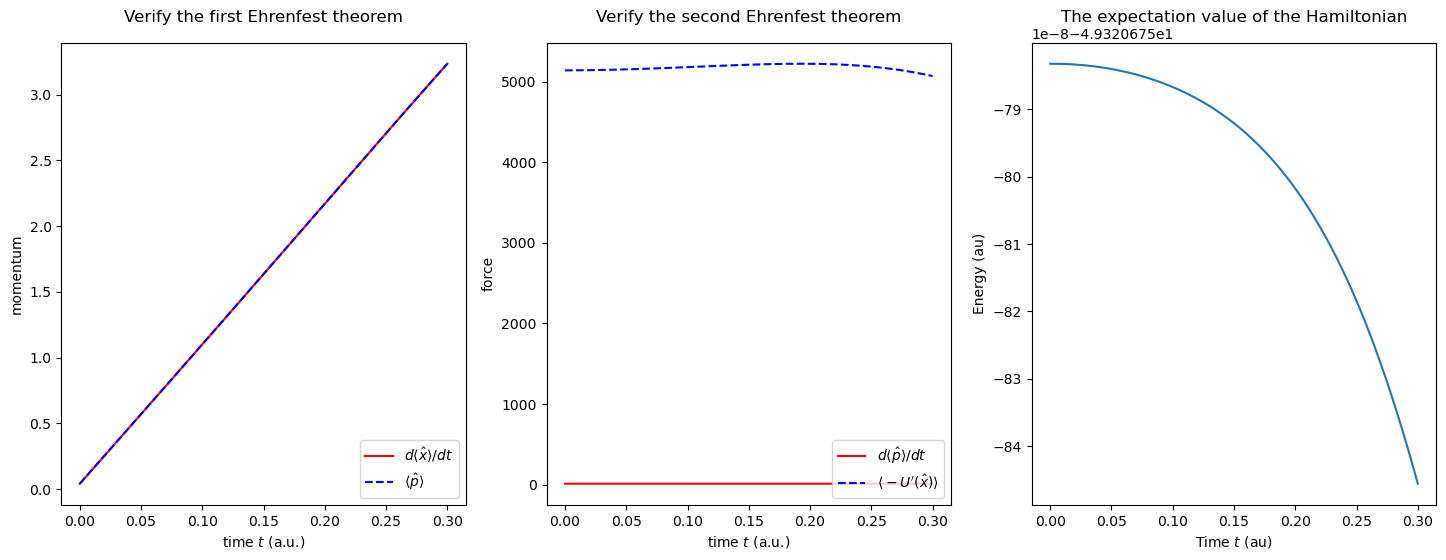

In [13]:
figure_number=0
# Plot tests of the Ehrenfest theorems
figefr = plt.figure(figure_number, figsize=(24,6))
plot_title = 'EFT-{}param'.format(_)
figure_number += 1
time = l2r['times']
plt.subplot(141)
plt.title("Verify the first Ehrenfest theorem", pad=15)
# Calculate the derivative using the spline interpolation because times is not a linearly spaced array
plt.plot(time, UnivariateSpline(time, l2r['x_average'], s=0).derivative()(time),
         '-r', label='$d\\langle\\hat{x}\\rangle / dt$')
plt.plot(time, l2r['x_average_rhs'], '--b', label='$\\langle\\hat{p}\\rangle$')
plt.legend(loc='lower right')
plt.ylabel('momentum')
plt.xlabel('time $t$ (a.u.)')

plt.subplot(142)
plt.title("Verify the second Ehrenfest theorem", pad=15)
# Calculate the derivative using the spline interpolation because times is not a linearly spaced array
plt.plot(time, UnivariateSpline(time, l2r['p_average'], s=0).derivative()(time),
         '-r', label='$d\\langle\\hat{p}\\rangle / dt$')
plt.plot(time, l2r['p_average_rhs'], '--b', label='$\\langle -U\'(\\hat{x})\\rangle$')
plt.legend(loc='lower right')
plt.ylabel('force')
plt.xlabel('time $t$ (a.u.)')

plt.subplot(143)
plt.title("The expectation value of the Hamiltonian", pad=15)

# Analyze how well the energy was preserved
h = np.array(l2r['hamiltonian_average'])
print(
    "\nHamiltonian is preserved within the accuracy of {:.1e} percent".format(
        100. * (1. - h.min() / h.max())
    )
)
print("Initial Energy {:.4e}".format(h[0]))
plt.plot(time, h)
plt.ylabel('Energy (au)')
plt.xlabel('Time $t$ (au)')
plt.show()